# **Data Study Notebook**

## Objectives

- Answer Business Requirement 1:
The client is interested in discovering how house attributes correlate with the sale price.
- Generate correlation & visualization code for the Streamlit dashboard.


## Inputs

* outputs/datasets/collection/HousePrices.csv

## Outputs

* Generate code that answers business requirement 1 and can be used to build the Streamlit App.
* Creating plots to see correlation for the selected variables.


---

## Change Working Directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues/jupyter_notebooks'

We change the working directory to the parent of the current one using os.path.dirname() and os.chdir().

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/heritage-housing-issues'

---

## Load Data

In [4]:
import pandas as pd

df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,No,706,GLQ,150,548,RFn,1710,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,Gd,978,ALQ,284,460,RFn,1262,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,Mn,486,GLQ,434,608,RFn,1786,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.869214,No,216,ALQ,540,642,Unf,1717,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,Av,655,GLQ,490,836,RFn,2198,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


## Data Exploration

We start with a data profiling report to better understand the dataset. This helps us review variable types, distributions, missing values, and how each variable may relate to the target.

We use the ydata-profiling library to generate this report.

In [5]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The profiling report shows:
- Nine features contain missing values.
- EnclosedPorch and WoodDeckSF have the highest missing rates—90.7% and 89.4%, respectively.

### Create a new directory to save plots

In [6]:
import os

try:
    os.makedirs("docs/plots")
except Exception as e:
    print(e)

---

## Correlation and PPS Analysis

Our dataset includes four categorical variables stored as objects. We need to encode them to calculate correlation coefficients.

In [8]:
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder

cat_vars = df.select_dtypes(include="object").columns.tolist()

# Add missing 
imputer = CategoricalImputer(
    imputation_method="missing",
    variables=cat_vars
)
df_imputed = imputer.fit_transform(df)

encoder = OneHotEncoder(
    variables=cat_vars,
    drop_last=False
)
df_ohe = encoder.fit_transform(df_imputed)


/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


- After encoding, the dataset expands to 37 columns, with each category represented as a separate binary column (0 or 1).
- Next, we define functions to calculate correlation values, generate heatmaps, and display them.
- Each heatmap is saved to the docs directory for use in project documentation.

In [20]:
%matplotlib inline
import numpy as np
import ppscore as pps
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  """
  Function to create heatmap using correlations.
  """
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
     # Save heatmaps to docs folder
    if df.name == "corr_spearman":
      plt.savefig(f'docs/plots/heatmap_corr_spearman.png', bbox_inches='tight')
    else:
      plt.savefig(f'docs/plots/heatmap_corr_pearson.png', bbox_inches='tight')
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    """
    Function to create heatmap using pps.
    """
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      # Save heatmap to docs folder
      plt.savefig(f'docs/plots/heatmap_pps.png', bbox_inches='tight')
      plt.show()


def CalculateCorrAndPPS(df):
  """
  Function to calculate correlations and pps.
  """
  df_corr_spearman = df.corr(method="spearman")
  df_corr_spearman.name = 'corr_spearman'
  df_corr_pearson = df.corr(method="pearson")
  df_corr_pearson.name = 'corr_pearson'

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):
  """
  Function to display the correlations and pps.
  """

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


In [21]:
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline

# List of categorical variable names
cat_vars = df.select_dtypes(include="object").columns.tolist()

# Impute missing values with "Missing" then apply one-hot encoding
preprocess = Pipeline([
    ("impute_missing", CategoricalImputer(imputation_method="missing", variables=cat_vars)),
    ("one_hot",       OneHotEncoder(variables=cat_vars, drop_last=False)),
])

# 3. Create df_ohe in a single step
df_ohe = preprocess.fit_transform(df)

/home/cistudent/.local/lib/python3.12/site-packages/feature_engine/imputation/categorical.py:232: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[variable]):


In [22]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_ohe)

/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

PPS threshold - check PPS score IQR to decide threshold for heatmap 

          count   mean    std  min  25%  50%  75%    max
ppscore  1332.0  0.017  0.065  0.0  0.0  0.0  0.0  0.945


/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt



* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



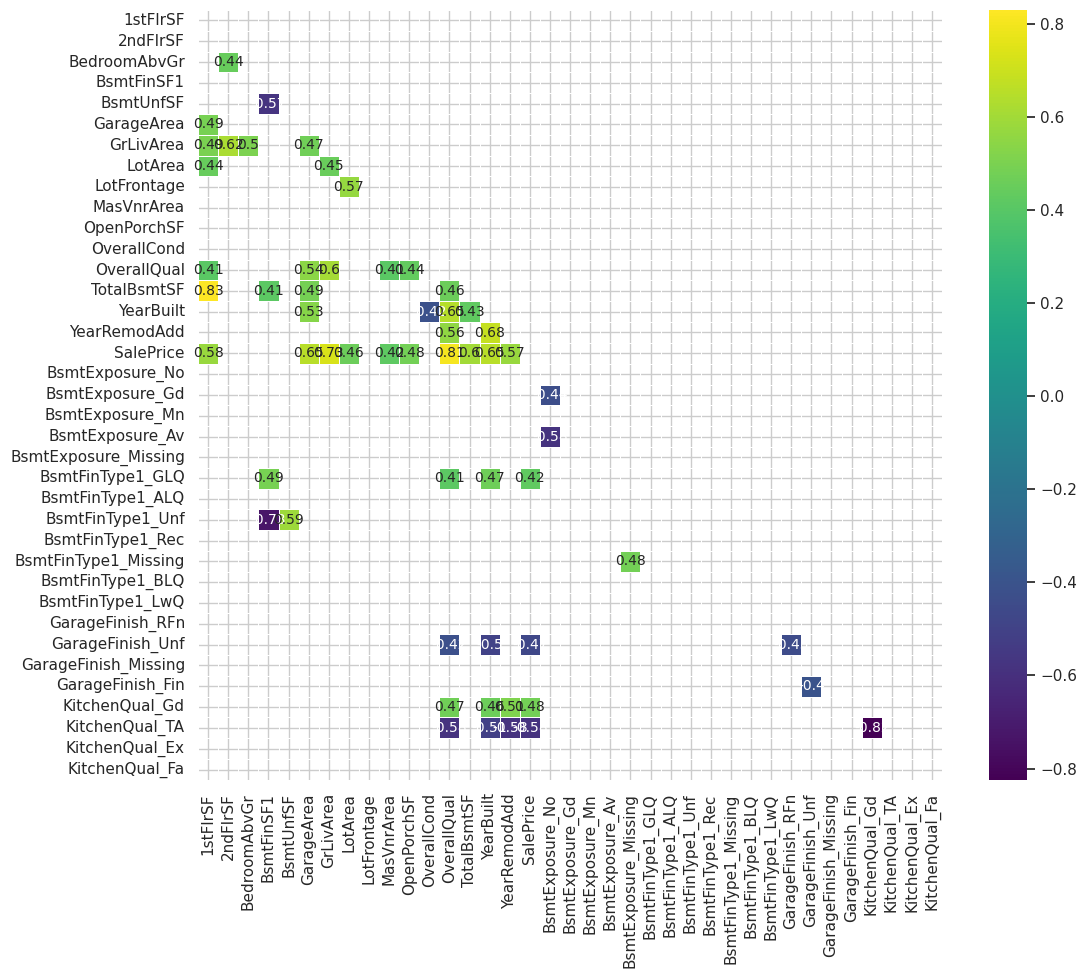



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



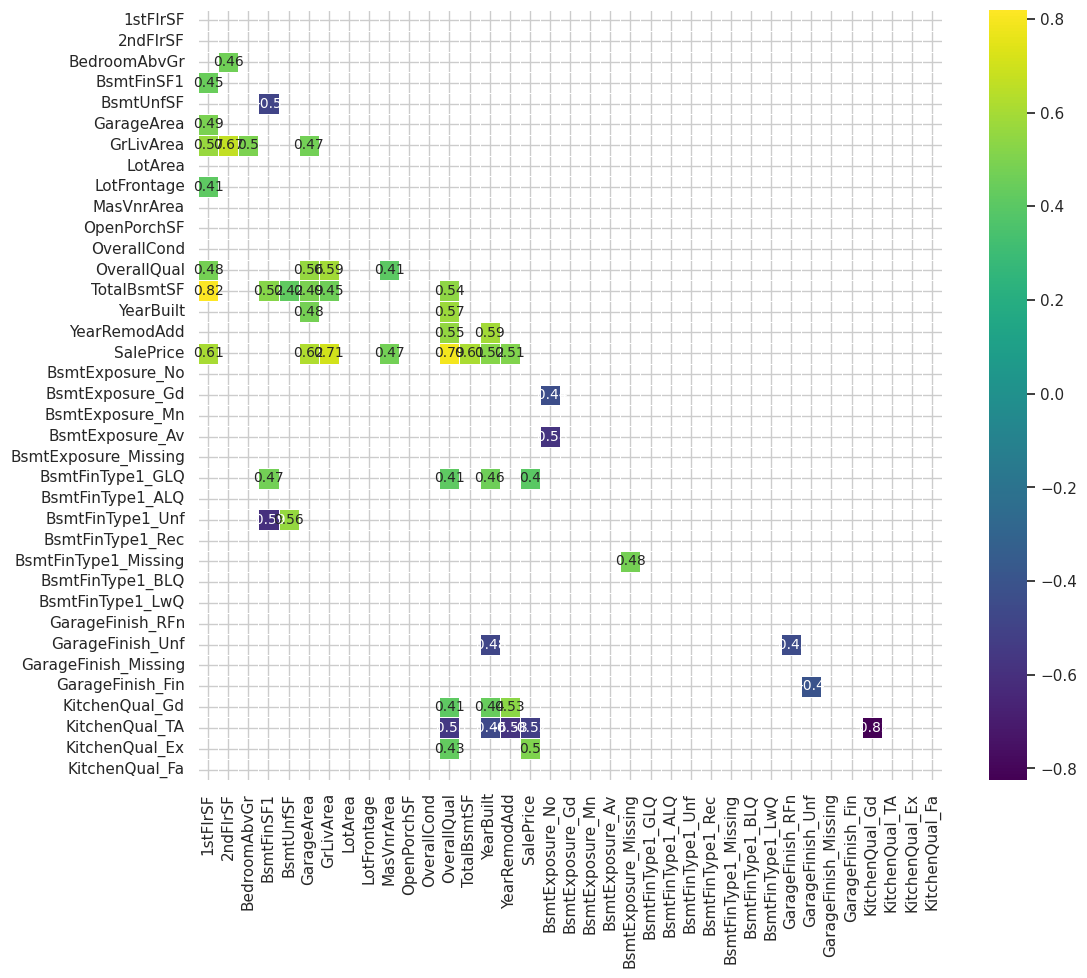



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



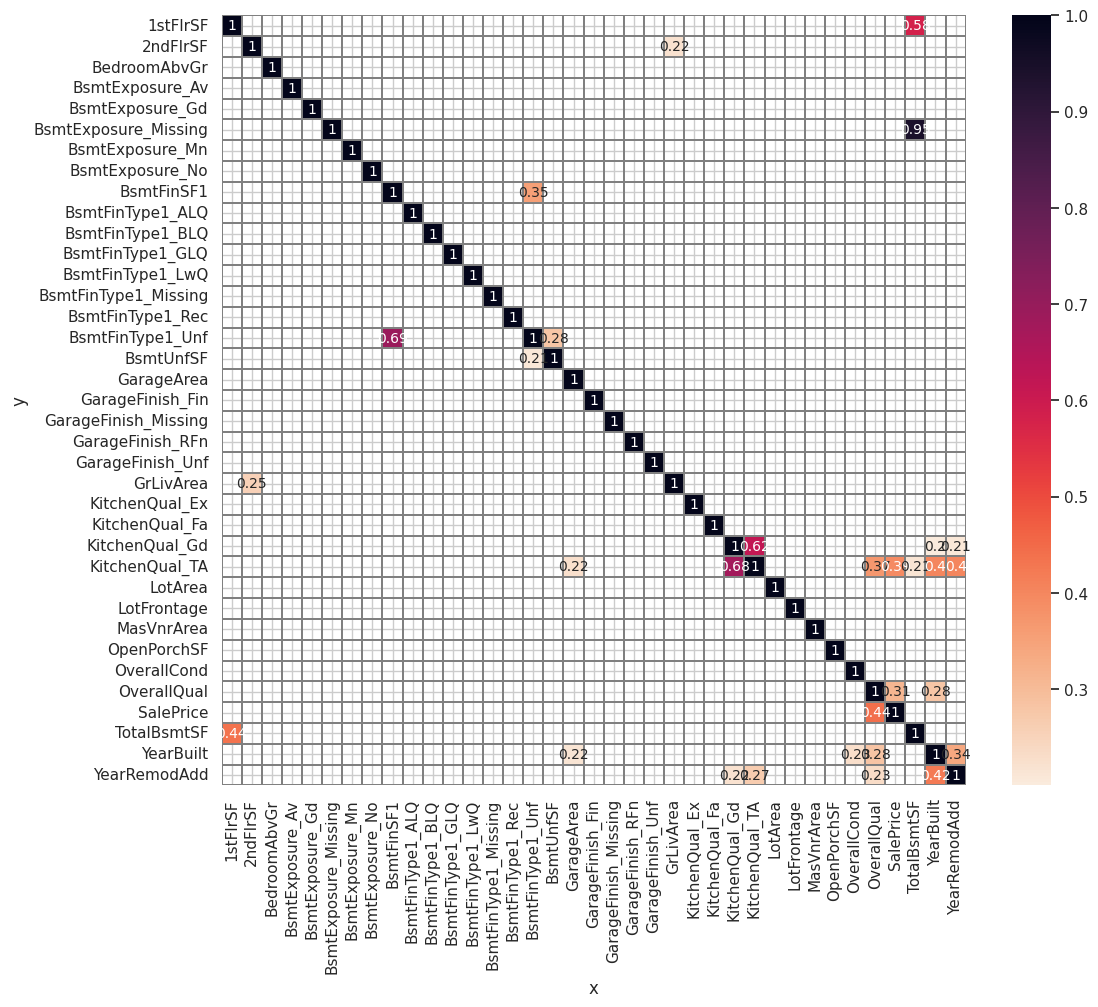

In [23]:
DisplayCorrAndPPS(
    df_corr_pearson=df_corr_pearson,
    df_corr_spearman=df_corr_spearman,
    pps_matrix=pps_matrix,
    CorrThreshold=0.4,
    PPS_Threshold=0.2,
    figsize=(12, 10),
    font_annot=10,
)

In [24]:
corr_spearman = (
    df_ohe.corr(method="spearman")["SalePrice"]
    .sort_values(key=abs, ascending=False)[1:]
    .head(10)
)
corr_spearman

OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
OpenPorchSF       0.477561
Name: SalePrice, dtype: float64

In [25]:
corr_pearson = (
    df_ohe.corr(method="pearson")["SalePrice"]
    .sort_values(key=abs, ascending=False)[1:]
    .head(10)
)
corr_pearson

OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64

In [26]:
top_n = 10
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

In [27]:
vars_to_study = [
    "1stFlrSF",
    "GarageArea",
    "GrLivArea",
    "KitchenQual",
    "MasVnrArea",
    "OpenPorchSF",
    "OverallQual",
    "TotalBsmtSF",
    "YearBuilt",
    "YearRemodAdd",
]
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'KitchenQual',
 'MasVnrArea',
 'OpenPorchSF',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

## Create EDA Dataset

We run EDA using features moderately or strongly correlated with SalePrice, creating a DataFrame that includes the target for visualization.

In [28]:
df_eda = df[vars_to_study + ["SalePrice"]]
df_eda.head()

,1stFlrSF,GarageArea,GrLivArea,KitchenQual,MasVnrArea,OpenPorchSF,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,548,1710,Gd,196.0,61,7,856,2003,2003,208500
1,1262,460,1262,TA,0.0,0,6,1262,1976,1976,181500
2,920,608,1786,Gd,162.0,42,7,920,2001,2002,223500
3,961,642,1717,Gd,0.0,35,7,756,1915,1970,140000
4,1145,836,2198,Gd,350.0,84,8,1145,2000,2000,250000


### Target Analysis

Distribution of Sales Price

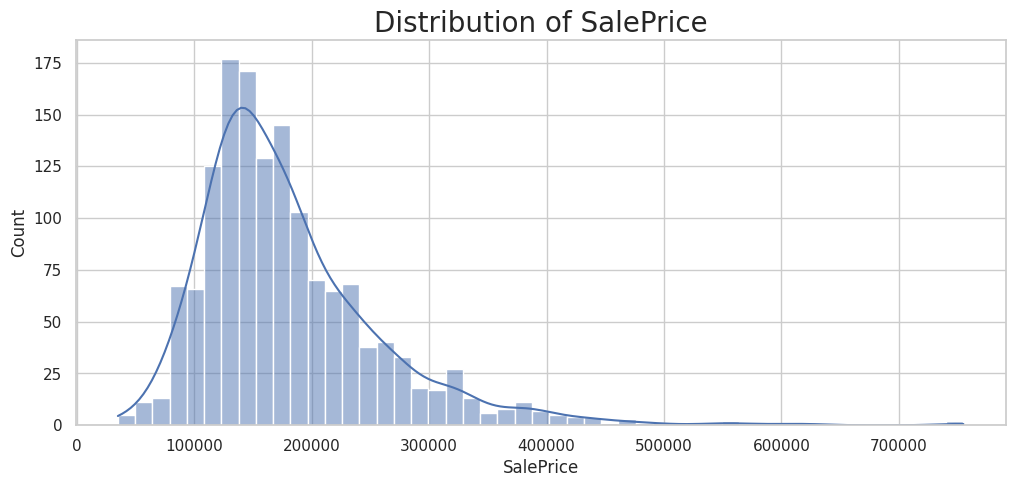

In [29]:
sns.set_style("whitegrid")
target_var = "SalePrice"
time = ["YearBuilt", "YearRemodAdd"]


def plot_target_hist(df, target_var):
    """
    Function to plot a histogram of the target and
    save the figure to folder.
    """
    plt.figure(figsize=(12, 5))
    sns.histplot(data=df, x=target_var, kde=True)
    plt.title(f"Distribution of {target_var}", fontsize=20)
    plt.savefig(f"docs/plots/hist_plot_{target_var}.png", bbox_inches="tight")
    plt.show()


plot_target_hist(df, target_var)

### Bivariate plots

To address business requirement 1, we plot SalePrice against key numerical and categorical features to explore their relationships.

<Figure size 1200x500 with 0 Axes>

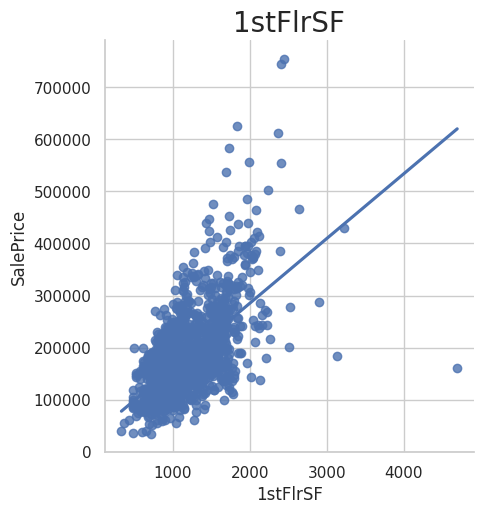

<Figure size 1200x500 with 0 Axes>

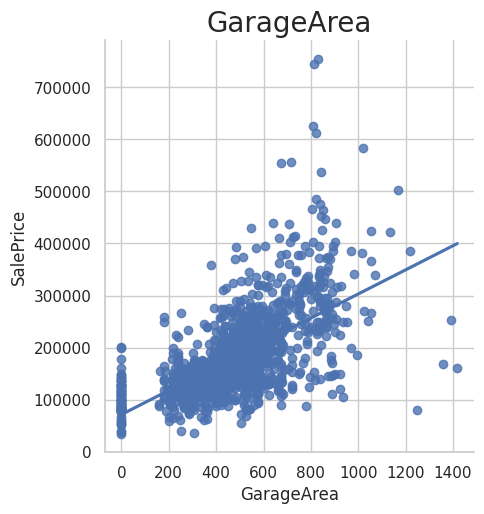

<Figure size 1200x500 with 0 Axes>

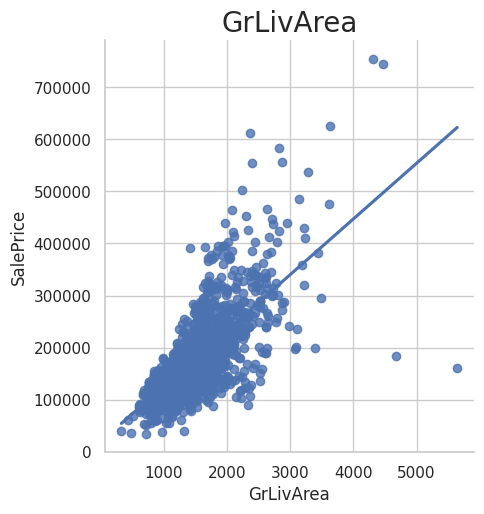

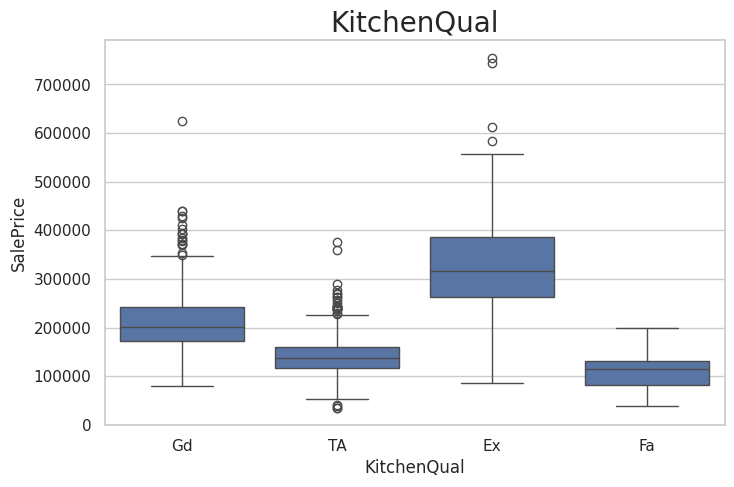

<Figure size 1200x500 with 0 Axes>

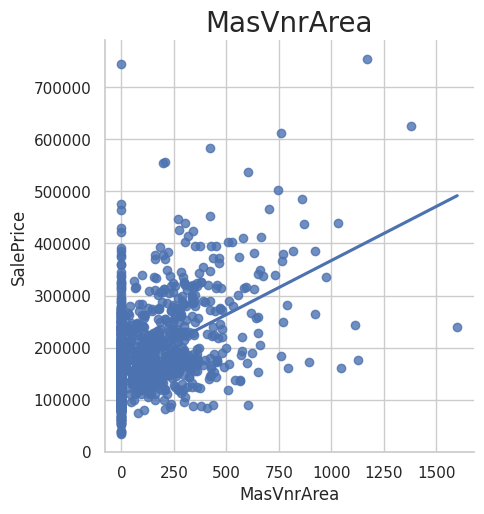

<Figure size 1200x500 with 0 Axes>

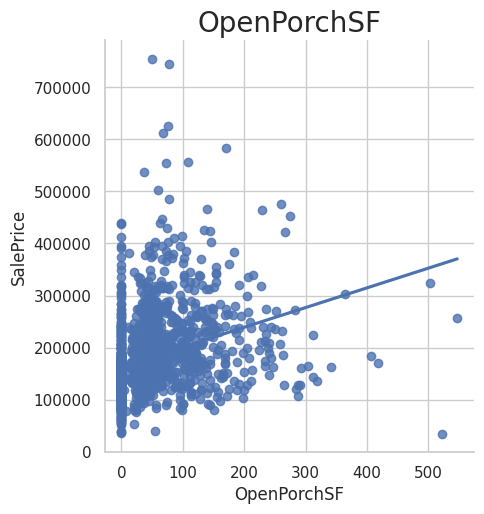

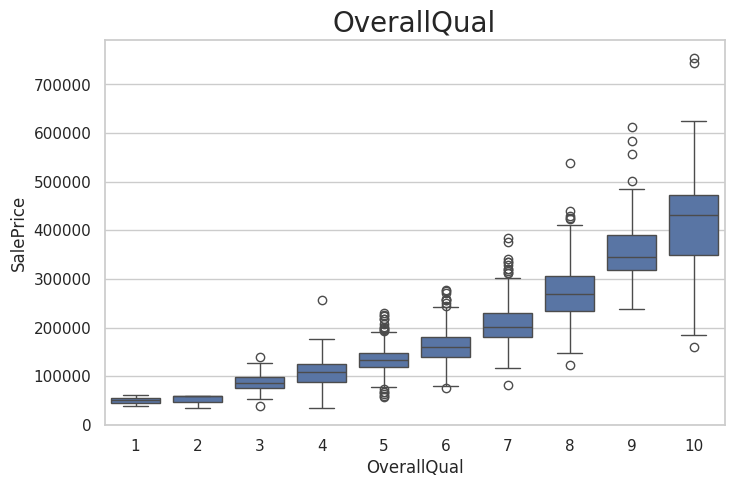

<Figure size 1200x500 with 0 Axes>

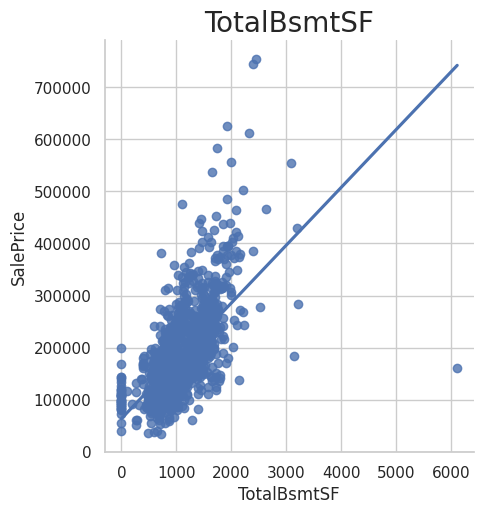

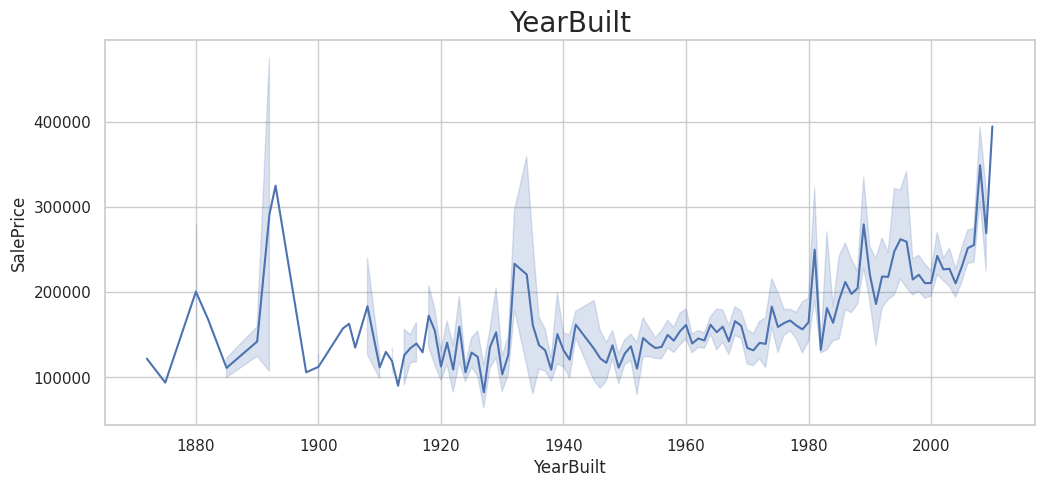

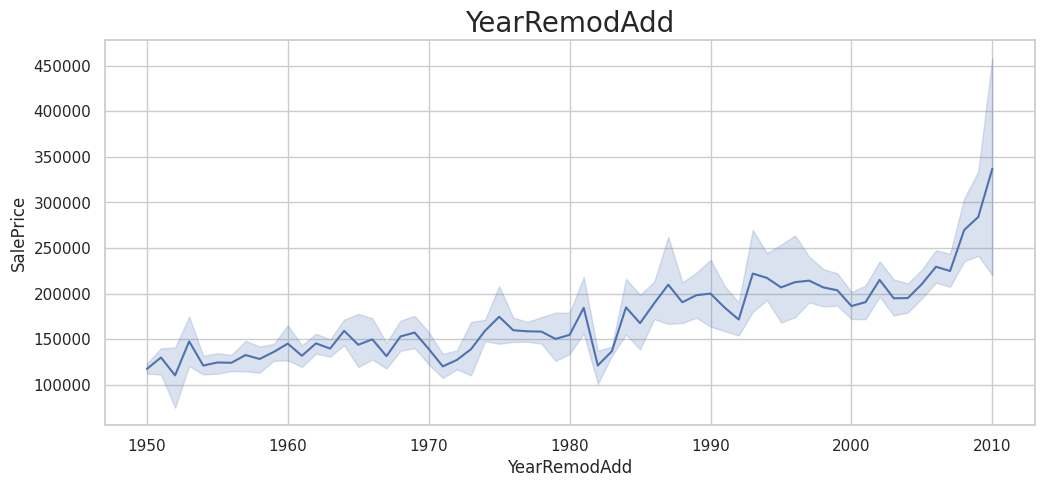

In [30]:
def plot_lm(df, col, target_var):
    """
    Function to create linear regression plots of the target and
    features with continuous values.
    It saves each figure to folder.
    """
    plt.figure(figsize=(12, 5))
    sns.lmplot(data=df, x=col, y=target_var, ci=None)
    plt.title(f"{col}", fontsize=20)
    plt.savefig(f"docs/plots/lm_plot_price_by_{col}.png", bbox_inches="tight")
    plt.show()


def plot_line(df, col, target_var):
    """
    Function to create a line plot of the target and
    time variables (years).
    It saves each figure to folder.
    """
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x=col, y=target_var)
    plt.title(f"{col}", fontsize=20)
    plt.savefig(f"docs/plots/line_plot_price_by_{col}.png", bbox_inches="tight")
    plt.show()


def plot_box(df, col, target_var):
    """
    Function to create a box plot of the target and
    categorical variables.
    It saves each figure to folder.
    """
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=col, y=target_var)
    plt.title(f"{col}", fontsize=20)
    plt.savefig(f"docs/plots/box_plot_price_by_{col}", bbox_inches="tight")
    plt.show()


for col in vars_to_study:
    if len(df_eda[col].unique()) <= 10:
        plot_box(df_eda, col, target_var)
        print("\n\n")
    else:
        if col in time:
            plot_line(df_eda, col, target_var)
            print("\n\n")
        else:
            plot_lm(df_eda, col, target_var)
            print("\n\n")

The plots show that higher feature values generally align with higher sale prices. However, outliers are present, similar to what we saw in the target variable.
We’ll address these outliers during feature engineering to prepare the data for modeling.

---

## Summary and the Next Steps

**Summary**

The correlation analysis confirms:
- 'OverallQual', 'GrLivArea', and 'YearBuilt' show strong correlation with 'SalePrice'.
- Variables related to size (e.g., 1stFlrSF, TotalBsmtSF) and condition (e.g., OverallQual) are most predictive.
- From 1980 onwards, newer homes see significant price increases.

**Next Step**:
Proceed to Feature Engineering notebook.

